# Aulão LLM's e Agentes - RAG e Memória


## Etapa 1 - Chat para responder dúvidas de responsáveis

Nesta aula, vamos construir um RAG simples para responder dúvidas de responsáveis usando como fonte um PDF da escola (ex.: proposta pedagógica, FAQ de matrícula, política de bolsas).

Aqui tem um esquema do RAG, passaremos por cada etapa dessa, que com o Langchain fica bem simples de implementar:

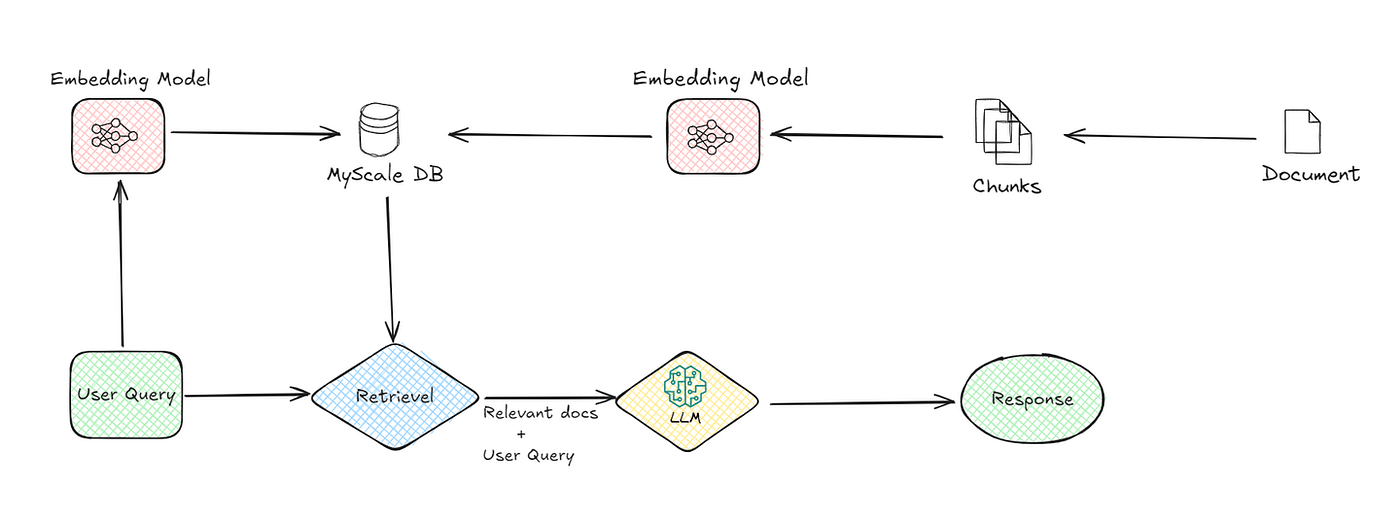


Entretanto, se você quer fazer algo mais robusto, você consegue ter mais "autonomia" e controle do RAG usando o LIama Index. 

Dá uma olhada no *Revista Vanguard.pdf*, sem o RAG teríamos que inputar o conteúdo completo do PDF no prompt, o que não é viável. O que faremos é usar o RAG para buscar os trechos mais relevantes do PDF de acordo com a pergunta do usuário, essa é a magia central dessa técnica.

Tratando do documento, a primeira etapa é transformar o documento em chunks e gerar embeddings para cada chunk.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('Revista Vanguard.pdf')
# isso aqui poderia ser uma lista de 
docs = loader.load()

print(f"Páginas carregadas: {len(docs)}\n\n")
print(f"\nExemplo de metadata:{docs[0].metadata}\n\n")
print(f"\nTrecho do texto: {docs[0].page_content[:300]}\n\n")

C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Páginas carregadas: 9
Exemplo de metadata: {'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': 'PyPDF', 'creationdate': '', 'title': 'Revista Vanguard: A Jornada para a Excelência', 'source': 'Revista Vanguard.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}
Trecho do texto: Revista  Vanguard:  A  Jornada  para  a  Excelência  Descubra  por  que  o  Vanguard  é  a  escolha  certa  para  o  futuro  do  seu  ﬁlho.  
Palavra  do  Fundador:  A  Paixão  que  Transforma  Vidas  Toda  grande  história  começa  com  um  sonho.  A  nossa  nasceu  em  2000,  da  "paixão  pelo  
e


In [1]:
from openai import OpenAI

client = OpenAI()
historico = [{"role": "system", "content": "Você é um atendente virtual de uma escola, "
"receba e acolha o responsável. Responda de maneira objetiva"}]

# respostas pré-definidas pra agilizar
mensagens_responsavel = [
    "Olá, gostaria de saber sobre valores para o ano que vem.",
    "Meu filho está no 6º ano, como funciona o ensino de vocês?",
    "Vocês têm atividades extracurriculares?",
    "E a questão da segurança no colégio, como é feita?",
    "Quais são os diferenciais da escola em relação às outras da região?",
    # aqui vamos colocar uma pergunta para ver a administração da memória
    "Perfeito! Agora, para qual série o meu filho está matriculado?"
]


for mensagem in mensagens_responsavel:
    historico.append({"role": "user", "content": mensagem})

    resposta = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=historico,
        temperature=0.7
    )

    resposta_texto = resposta.choices[0].message.content

    # Salvando resposta no histórico
    historico.append({"role": "assistant", "content": resposta_texto})

    print(f"\nUsuário: {mensagem}")
    print(f"Assistente: {resposta_texto}")



Usuário: Olá, gostaria de saber sobre valores para o ano que vem.
Assistente: Olá! Fico feliz em ajudar. Para fornecer informações sobre os valores para o próximo ano, você poderia me informar qual nível de ensino está interessado?

Usuário: Meu filho está no 6º ano, como funciona o ensino de vocês?
Assistente: No 6º ano, nossa escola oferece uma abordagem integrada, com foco no desenvolvimento acadêmico e social dos alunos. As disciplinas incluem Português, Matemática, Ciências, História, Geografia, Artes e Educação Física. Também promovemos atividades extracurriculares para enriquecer a experiência dos alunos.

Se precisar de mais detalhes sobre o currículo ou valores, estou à disposição!

Usuário: Vocês têm atividades extracurriculares?
Assistente: Sim, temos diversas atividades extracurriculares! Oferecemos opções como esportes, artes, música, teatro e clubes de interesse. Essas atividades visam desenvolver habilidades sociais, criatividade e trabalho em equipe. Se precisar de inf

Legal! Ele lembrou do ano do aluno. Evidentemente, quanto maior o histórico, mais ele vai ser perder desse jeito. Como trabalhar com a memória é um desafio interessante.

Vamos começar a entender como fazer isso com o Langchain. 

É importante dizer que quando eu fiz o Chatbot o Langchain trabalhava de um jeito diferente, tinham algumas opções que você podia, por exemplo:

1. Resumir o histórico
2. Trabalhar com uma janela de mensagens(ex: últimas 5 mensagens)

Agora eles excluiram essas opções e padronizaram o mesmo uso de memória que usam para os agentes. Então, vamos ver como fazer isso.